<a href="https://colab.research.google.com/github/QSRafael/desafios-nlp/blob/master/receipts/DesafioMostQI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafio mostQi - Recibos de Pagamento

Rafael de Queiroz Souza

Nesse desafio, está sendo usado o dataset SRIOE, que contém 626 recibos escaneados e rotulados para treino, e 347 para teste.

Usarei o modelo pré-treinado LayoutLMv2 proposto por Yang Xu, Yiheng Xu, Tengchao Lv, Lei Cui, Furu Wei, Guoxin Wang, Yijuan Lu, Dinei Florencio, Cha Zhang, Wanxiang Che, Min Zhang e Lidong Zhou, que foi treinado para extração de informações de documentos digitalizados, classificação de imagens de documentos e resposta visual de perguntas.
Usarei a Biblioteca Transformers, que fornece o modelo citado de forma fácil, além de várias ferramentas para ajustar o conjunto de dados.

## Preparando o ambiente

In [ ]:
%%capture
!pip install transformers
!pip install sentencepiece
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install -q datasets seqeval
!pip install -q pyyaml==5.1
!python -m pip install -q 'git+https://github.com/facebookresearch/detectron2.git'
!pip install google.colab

import pandas as pd
import numpy as np
import pytesseract
import json
import torch
from torch.utils.data import DataLoader
from os import listdir
from os.path import isfile, join
from PIL import Image, ImageDraw, ImageFont
from tqdm.notebook import tqdm
from datasets import Dataset, DatasetDict
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D, load_metric
from transformers import LayoutLMv2Processor, LayoutLMv2ForTokenClassification, AdamW
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/MyDrive/recibos/'

## Definindo algumas funções que serão necessárias

In [ ]:
# converte os dados de saída do pytesseract em um dataframe apenas com os dados necessários
def data_to_Dataframe(data):
  df = pd.DataFrame([x.split('\t') for x in data.split('\n')] )
  df = df.drop([0,1,2,3,4,5,10], axis=1) #tira colunas desnecessárias
  df.columns = df.iloc[0] #define nome das colunas
  df = df.drop([0], axis=0) #tira a primeira linha
  df.replace("", float("NaN"), inplace=True) #substitui vazio por NaN
  df.dropna(subset = ["text"], inplace=True) #tira linhas vazias
  df['label'] = 0 #acrescenta label igual a 0
  return df

# passa por todas e compara com o ressultado, se for verdadeiro, seta com o rótulo correto
def setLabel(df, data):
  try:
    for word in data["address"].split():
      df.loc[df['text'] == word, 'label'] = 1
  except:
    print('imagem(' + str(i) + ') não possui endereço')
  try:
    for word in data["company"].split():
      df.loc[df['text'] == word, 'label'] = 2
  except:
    print('imagem(' + str(i) + ') não possui compania')
  try:
    for word in data["date"].split():
      df.loc[df['text'] == word, 'label'] = 3
  except:
    print('imagem(' + str(i) + ') não possui data')
  try:
    for word in data["total"].split():
      df.loc[df['text'] == word, 'label'] = 4
  except:
    print('imagem(' + str(i) + ') não possui total')
    
# converte os bboxs do pytesseract no formato aceito pelo LayoutLMv2
# de [x0, y0, w, h] para [x0, y0, x1, y1] que é igual a [x0, y0, x0+w, y0+h]
def createBBOXList(df, width, height):
  df['left'] = pd.to_numeric(df['left'])
  df['top'] = pd.to_numeric(df['top'])
  df['width'] = pd.to_numeric(df['width'])
  df['height'] = pd.to_numeric(df['height'])
  bboxlist = []
  for index, row in df.iterrows():
    list1 = []
    list1.append(int((row['left']/width)*1000))
    list1.append(int((row['top']/height)*1000))
    list1.append(int(((row['left']+row['width'])/width)*1000))
    list1.append(int(((row['top']+row['height'])/height)*1000))
    bboxlist.append(list1);
  return bboxlist

# pré processa os dados
def preprocess_data(examples):
  images = [Image.open(path).convert("RGB") for path in examples['image_path']]
  words = examples['words']
  boxes = examples['bboxes']
  word_labels = examples['ner_tags']
  
  encoded_inputs = processor(images, words, boxes=boxes, word_labels=word_labels,
                             padding="max_length", truncation=True)
  
  return encoded_inputs

# desnormaliza as bboxs
def unnormalize_box(bbox, width, height):
     return [
         width * (bbox[0] / 1000),
         height * (bbox[1] / 1000),
         width * (bbox[2] / 1000),
         height * (bbox[3] / 1000),
     ]

#tira a letra B do label
def iob_to_label(label):
    if label[0]=='B':
      label = label[2:]
    else:
      label = 'other'
    return label

## Criando o DataSet

### Listando arquivos
Para facilitar, renomeei os arquivos no formato 'input(x).jpg', 'output(x).txt e test(y).jpg

In [ ]:
input_files = [f for f in listdir(root_path +'input/') if isfile(join(root_path + 'input/', f))]
output_files = [f for f in listdir(root_path + 'output/') if isfile(join(root_path +'output/', f))]
print(input_files)
print(output_files)

['input(1).jpg', 'input(2).jpg', 'input(3).jpg', 'input(4).jpg', 'input(5).jpg', 'input(6).jpg', 'input(8).jpg', 'input(7).jpg', 'input(10).jpg', 'input(9).jpg', 'input(12).jpg', 'input(11).jpg', 'input(33).jpg', 'input(36).jpg', 'input(32).jpg', 'input(35).jpg', 'input(34).jpg', 'input(37).jpg', 'input(38).jpg', 'input(40).jpg', 'input(39).jpg', 'input(46).jpg', 'input(31).jpg', 'input(48).jpg', 'input(50).jpg', 'input(49).jpg', 'input(47).jpg', 'input(51).jpg', 'input(52).jpg', 'input(22).jpg', 'input(21).jpg', 'input(16).jpg', 'input(19).jpg', 'input(20).jpg', 'input(17).jpg', 'input(18).jpg', 'input(88).jpg', 'input(87).jpg', 'input(75).jpg', 'input(74).jpg', 'input(241).jpg', 'input(227).jpg', 'input(121).jpg', 'input(93).jpg', 'input(166).jpg', 'input(226).jpg', 'input(111).jpg', 'input(86).jpg', 'input(85).jpg', 'input(73).jpg', 'input(72).jpg', 'input(92).jpg', 'input(110).jpg', 'input(109).jpg', 'input(71).jpg', 'input(70).jpg', 'input(84).jpg', 'input(108).jpg', 'input(27).jp

Agora todos os arquivos da pasta serão percorridos, e um a um será lido pelo pytesseract e salvo em um dicionário.

Para o modelo, precisamos de 4 informações: a imagem, as palavras extraidas, o label esperado para cada palavra e as BBoxs

In [ ]:
list_data = []
for i in range(1,len(input_files)):
  #lendo e extraindo texto
  image_path = '/content/gdrive/MyDrive/recibos/input/input('+str(i)+').jpg'
  image = Image.open(image_path) 
  extract = pytesseract.image_to_data(image)
  #colocando dados extraidos por ocr no dataframe
  df = data_to_Dataframe(extract)

  #abrindo as respostas, e setando os labels
  f = open('/content/gdrive/MyDrive/recibos/output/output('+str(i)+').txt') 
  data = json.load(f)
  setLabel(df, data)

  #arrumando as bbox
  width, height = image.size
  word_list = df['text'].to_list()
  label_list = df['label'].to_list()

  #criando um dicionário e adicionando a uma lista
  mydict = {'bboxes':createBBOXList(df, width, height), 'words': word_list,
            'ner_tags':label_list, 'image_path':image_path}
  list_data.append(mydict)

Criando um DataFrame a partir da lista, criando um DataSet a partir do DataFrame, separando em teste e validação e salvando no disco

In [ ]:
df = pd.DataFrame(list_data) #criando um DataFrame a partir da lista
ds = Dataset.from_pandas(df) #criando um DataSet a partir do DataFrame
ds = ds.train_test_split() #separando em test e validação
ds.save_to_disk(root_path + 'dataset.csv')
ds

,bboxes,words,ner_tags,image_path
0,"[[161, 31, 272, 54], [298, 36, 494, 54], [520,...","[tan, woon, yann, BOOK, TA, -K, (TAMAN, DAYA),...","[0, 0, 0, 2, 2, 0, 2, 2, 2, 2, 0, 0, 0, 1, 1, ...",/content/gdrive/MyDrive/recibos/input/input(1)...
1,"[[175, 51, 296, 74], [321, 56, 528, 74], [555,...","[tan, woon, yann, INDAH, GIFT, &, HOME, BECO, ...","[0, 0, 0, 2, 2, 2, 2, 0, 1, 1, 1, 1, 0, 1, 1, ...",/content/gdrive/MyDrive/recibos/input/input(2)...
2,"[[265, 52, 376, 76], [403, 57, 601, 76], [627,...","[tan, woon, yann, MR, O.1.¥., (JOHOR), SDN, BH...","[0, 0, 0, 2, 0, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, ...",/content/gdrive/MyDrive/recibos/input/input(3)...
3,"[[221, 50, 331, 75], [357, 55, 555, 75], [581,...","[tan, woon, yann, YONGFATT, ENTERPRISE, (4M051...","[0, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...",/content/gdrive/MyDrive/recibos/input/input(4)...
4,"[[183, 44, 298, 67], [321, 49, 518, 67], [544,...","[tan, woon, yann, MR, O.T.Y., (M), SON, BHD, (...","[0, 0, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 0, ...",/content/gdrive/MyDrive/recibos/input/input(5)...
...,...,...,...,...
620,"[[10, 0, 798, 1], [0, 198, 3, 533], [116, 191,...","[ , , GNE, ONE, THREE, SEAFOOD, RESTAURANT, S...","[0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, ...",/content/gdrive/MyDrive/recibos/input/input(62...
621,"[[115, 198, 169, 214], [191, 198, 245, 214], [...","[ONE, ONE, THREE, SEAFOOD, RESTAURANT, SDN, BH...","[2, 2, 2, 2, 2, 2, 2, 0, 1, 1, 1, 1, 1, 1, 1, ...",/content/gdrive/MyDrive/recibos/input/input(62...
622,"[[117, 211, 171, 227], [192, 211, 247, 227], [...","[ONE, ONE, THREE, SEAFOOD, RESTAURANT, SDN, BH...","[2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 1, 1, 1, 1, 1, ...",/content/gdrive/MyDrive/recibos/input/input(62...
623,"[[605, 0, 1000, 57], [113, 173, 168, 187], [18...","[4, ONE, ONE, THREE, SEAFOOD, RESTAURANT, SDN,...","[0, 2, 2, 2, 2, 2, 2, 2, 0, 1, 0, 1, 1, 1, 1, ...",/content/gdrive/MyDrive/recibos/input/input(62...


Descomente o código abaixo, caso já tenha o dataset pronto

In [ ]:
ds = DatasetDict.load_from_disk(root_path + 'dataset.csv')
ds

DatasetDict({
    train: Dataset({
        features: ['bboxes', 'words', 'ner_tags', 'image_path'],
        num_rows: 468
    })
    test: Dataset({
        features: ['bboxes', 'words', 'ner_tags', 'image_path'],
        num_rows: 157
    })
})

## Pré-Processamento dos dados

Temos 4 rótulos para indentificar: ```B-address```, ```B-company```, ```B-date``` e ```B-total```. O restante classificaremos como  ```O```,

In [ ]:
labels = ['O', 'B-address', 'B-company', 'B-date', 'B-total']
label2id = {'O':0, 'B-address':1, 'B-company':2, 'B-date':3, 'B-total':4}
id2label = {0:'O', 1:'B-address', 2:'B-company', 3:'B-date', 4:'B-total'}
# cores para cada label
label2color = {'address':'blue', 'company':'green', 'date':'orange', 'total':'violet', 'other': 'gray'}

O ```LayoutLMv2Processor``` contém todas as funcionalidades que precisamos para preparar os dados para o modelo.

In [ ]:
processor = LayoutLMv2Processor.from_pretrained("microsoft/layoutlmv2-base-uncased", revision="no_ocr")

# definindo as features
features = Features({
    'image': Array3D(dtype="int64", shape=(3, 224, 224)),
    'input_ids': Sequence(feature=Value(dtype='int64')),
    'attention_mask': Sequence(Value(dtype='int64')),
    'token_type_ids': Sequence(Value(dtype='int64')),
    'bbox': Array2D(dtype="int64", shape=(512, 4)),
    'labels': Sequence(ClassLabel(names=labels)),
})

train_dataset = ds['train'].map(preprocess_data, batched=True, remove_columns=ds['train'].column_names,
                                      features=features)
test_dataset = ds['test'].map(preprocess_data, batched=True, remove_columns=ds['test'].column_names,
                                      features=features)

Loading cached processed dataset at /content/gdrive/MyDrive/recibos/dataset.csv/train/cache-bfe0d20f3dded128.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
#setando o formato para pytorch
train_dataset.set_format(type="torch", device="cuda")
test_dataset.set_format(type="torch", device="cuda")
#criando o dataloader
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=2)

## Treinando o modelo

In [ ]:
model = LayoutLMv2ForTokenClassification.from_pretrained('microsoft/layoutlmv2-base-uncased',
                                                          num_labels=len(labels))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 6
t_total = len(train_dataloader) * num_train_epochs  

# colocando o modelo no modo de treino
model.train() 
for epoch in range(num_train_epochs):  
   for batch in tqdm(train_dataloader):
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = model(**batch) 
        loss = outputs.loss
        
        if global_step % 100 == 0:
          print(f"Loss after {global_step} steps: {loss.item()}")

        loss.backward()
        optimizer.step()
        global_step += 1

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use thePyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


  0%|          | 0/117 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:779: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:789: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

Loss after 0 steps: 1.6320329904556274
Loss after 100 steps: 0.5262792110443115


  0%|          | 0/117 [00:00<?, ?it/s]

Loss after 200 steps: 0.39727455377578735


  0%|          | 0/117 [00:00<?, ?it/s]

Loss after 300 steps: 0.1680089235305786


  0%|          | 0/117 [00:00<?, ?it/s]

Loss after 400 steps: 0.09817171096801758


  0%|          | 0/117 [00:00<?, ?it/s]

Loss after 500 steps: 0.08992743492126465


  0%|          | 0/117 [00:00<?, ?it/s]

Loss after 600 steps: 0.056071341037750244
Loss after 700 steps: 0.051023755222558975


In [ ]:
# salvar o modelo
torch.save(model, root_path + 'mymodel')

In [ ]:
# carregar o modelo
# model = torch.load(root_path + 'mymodel')

## Validando o modelo com o conjunto de validação

In [ ]:
metric = load_metric("seqeval")

# colocando o modelo em modo de avaliação
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids = batch['input_ids'].to(device)
        bbox = batch['bbox'].to(device)
        image = batch['image'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, bbox=bbox, image=image, attention_mask=attention_mask, 
                        token_type_ids=token_type_ids, labels=labels)
        
        # predições
        predictions = outputs.logits.argmax(dim=2)

        # removendo os tokens irrelevantes
        true_predictions = [
            [id2label[p.item()] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]
        true_labels = [
            [id2label[l.item()] for (p, l) in zip(prediction, label) if l != -100]
            for prediction, label in zip(predictions, labels)
        ]

        metric.add_batch(predictions=true_predictions, references=true_labels)

final_score = metric.compute()
print(final_score)

Downloading:   0%|          | 0.00/2.48k [00:00<?, ?B/s]

Evaluating:   0%|          | 0/79 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:779: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:789: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

{'address': {'precision': 0.8296703296703297, 'recall': 0.8669856459330143, 'f1': 0.8479176415535797, 'number': 1045}, 'company': {'precision': 0.9108695652173913, 'recall': 0.8026819923371648, 'f1': 0.8533604887983706, 'number': 522}, 'date': {'precision': 0.8802395209580839, 'recall': 1.0, 'f1': 0.9363057324840766, 'number': 147}, 'total': {'precision': 0.8447488584474886, 'recall': 0.8371040723981901, 'f1': 0.8409090909090909, 'number': 221}, 'overall_precision': 0.8550051599587203, 'overall_recall': 0.8563307493540052, 'overall_f1': 0.8556674412600052, 'overall_accuracy': 0.9693159789531985}


Temos como resultado as seguintes métricas:

---
*   Address:
 *   precision: 0.82
 *   recall: 0.86
 *   f1: 0.84
*   Company:
 *   precision: 0.91
 *   recall: 0.80
 *   f1: 0.85
*   Date:
 *   precision: 0.88
 *   recall: 1.0
 *   f1: 0.93
*   Total:
 *   precision: 0.84
 *   recall: 0.83
 *   f1: 0.84
 ---
*   Geral:
 *   precision: 0.85
 *   recall: 0.85
 *   f1: 0.85
 *   accuracy: 0.96


## Analise de um exemplo

Carregando uma imagem do conjunto de validação

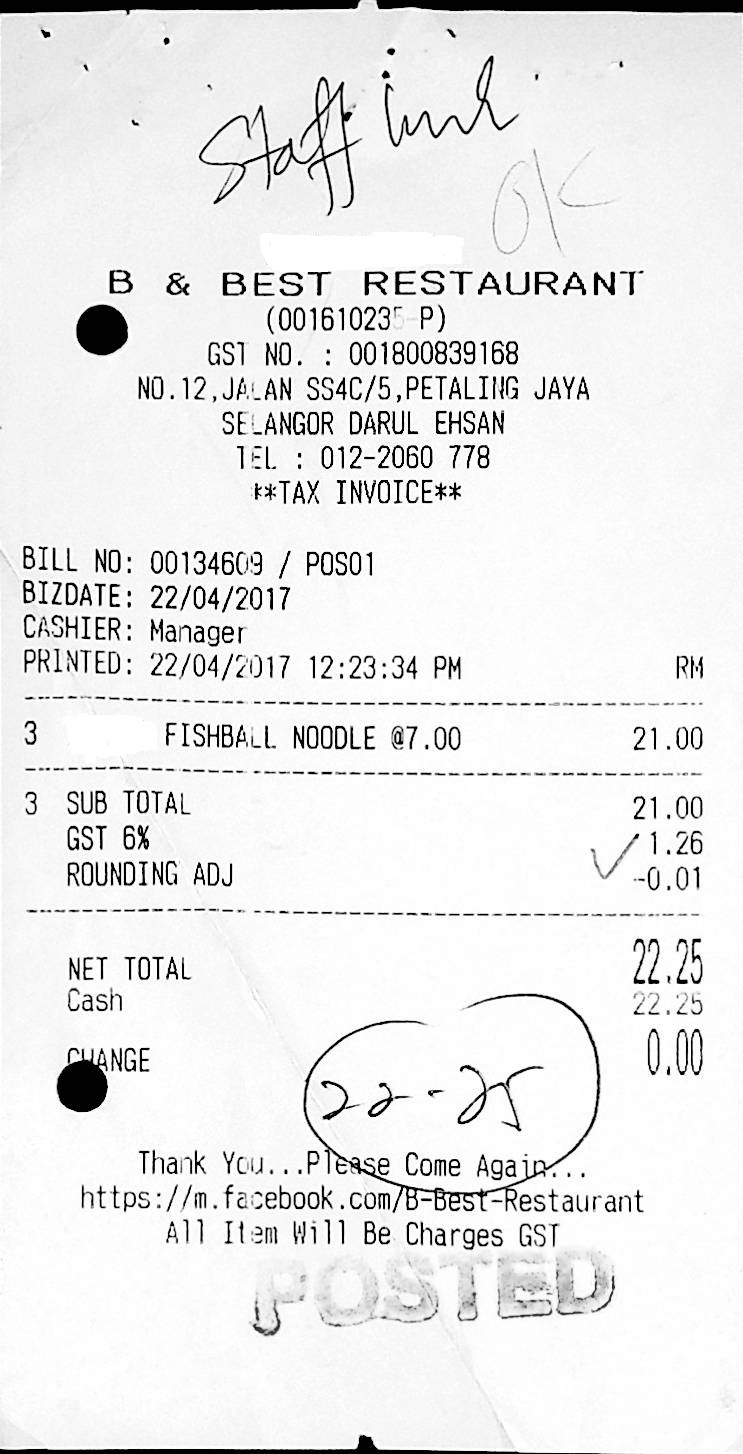

In [ ]:
example = ds["test"][5]
image = Image.open(example['image_path'])
image = image.convert("RGB")
image

Passando a imagem pelo modelo:

In [ ]:
encoded_inputs = processor(image, example['words'], boxes=example['bboxes'], word_labels=example['ner_tags'],
                           padding="max_length", truncation=True, return_tensors="pt")
labels = encoded_inputs.pop('labels').squeeze().tolist()
for k,v in encoded_inputs.items():
  encoded_inputs[k] = v.to(device)
outputs = model(**encoded_inputs)

predictions = outputs.logits.argmax(-1).squeeze().tolist()
token_boxes = encoded_inputs.bbox.squeeze().tolist()

width, height = image.size

true_predictions = [id2label[prediction] for prediction, label in zip(predictions, labels) if label != -100]
true_labels = [id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:779: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // self.config.image_feature_pool_shape[1]
/usr/local/lib/python3.7/dist-packages/transformers/models/layoutlmv2/modeling_layoutlmv2.py:789: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  // se

In [ ]:
print(true_predictions)
print(true_labels)

['B-company', 'B-company', 'B-company', 'B-company', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-date', 'O', 'O', 'O', 'B-date', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-total', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['B-company', 'B-company', 'B-company', 'B-company', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-address', 'B-address', 'B-address', 'B-address', 'B-address', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-date', 'O', 'O', 'O', 'B-date', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-total', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-company']


Temos como resultado:

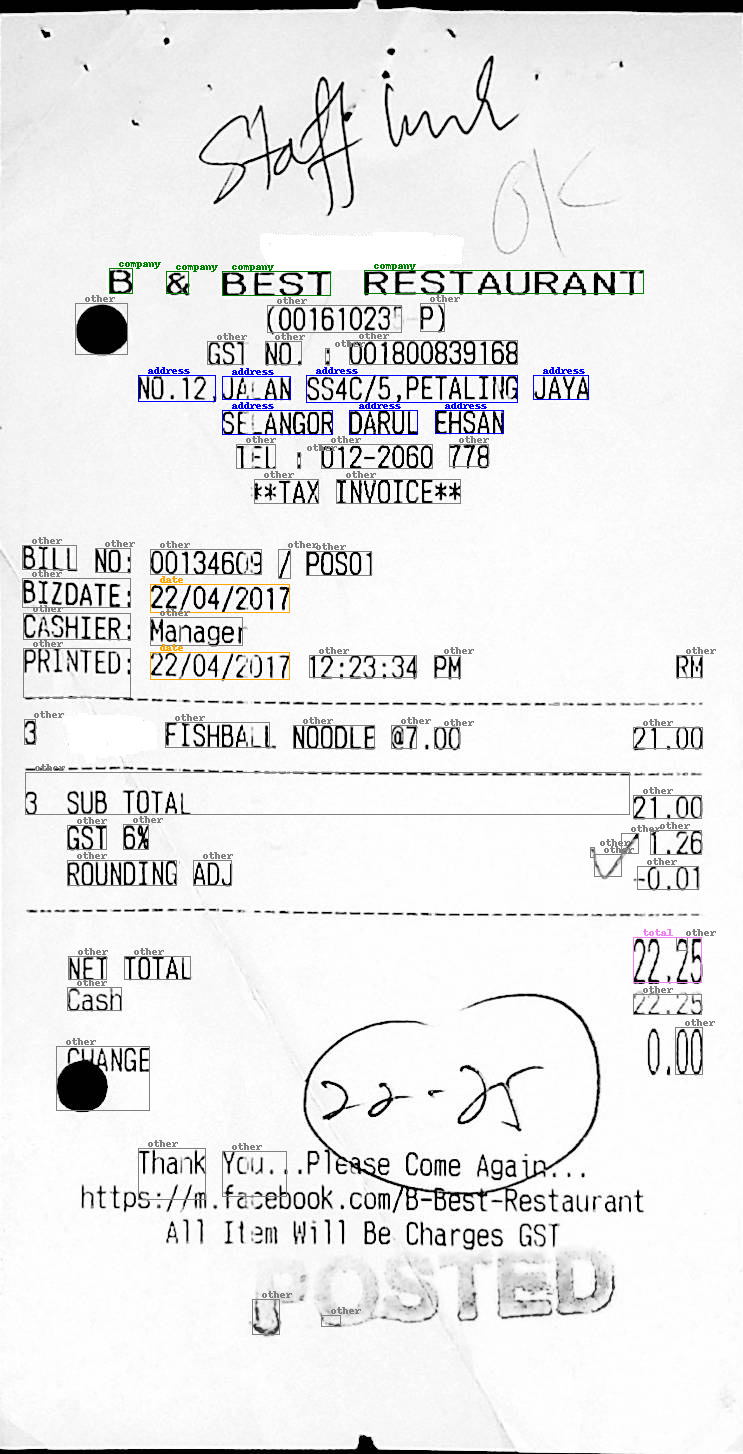

In [ ]:
draw = ImageDraw.Draw(image)
font = ImageFont.load_default()

for prediction, box in zip(true_predictions, true_boxes):
    predicted_label = iob_to_label(prediction).lower()
    draw.rectangle(box, outline=label2color[predicted_label])
    draw.text((box[0] + 10, box[1] - 10), text=predicted_label, fill=label2color[predicted_label], font=font)

image

## O que precisa melhorar?